In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [2]:
device = torch.device('cuda')

In [3]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 50, stride=5, padding=25)
        self.bn1 = nn.BatchNorm1d(64)
        self.activation1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=10, stride=5)
        
        ##########################################################################
        self.conv2a_1 = nn.Conv1d(64, 64, 1, stride=1, padding=1)
        self.bn2a_1 = nn.BatchNorm1d(64)
        
        self.conv2a_2a = nn.Conv1d(64, 64, 10, stride=1, padding=5)
        self.bn2a_2a = nn.BatchNorm1d(64)
        self.activation2a_2a = nn.ReLU()
        
        self.conv2a_2b = nn.Conv1d(64, 64, 10, stride=1, padding=5)
        self.bn2a_2b = nn.BatchNorm1d(64)
        
        self.activation2a = nn.ReLU()
        
        
        ##########################################################################
        self.conv3a_1 = nn.Conv1d(64, 128, 1, stride=5, padding=1)
        self.bn3a_1 = nn.BatchNorm1d(128)
        
        self.conv3a_2a = nn.Conv1d(64, 128, 10, stride=5, padding=5)
        self.bn3a_2a = nn.BatchNorm1d(128)
        self.activation3a_2a = nn.ReLU()
        
        self.conv3a_2b = nn.Conv1d(128, 128, 10, stride=1, padding=5)
        self.bn3a_2b = nn.BatchNorm1d(128)
        
        self.activation3a = nn.ReLU()
        
        
        ##########################################################################
        self.conv4a_1 = nn.Conv1d(128, 256, 1, stride=5, padding=1)
        self.bn4a_1 = nn.BatchNorm1d(256)
        
        self.conv4a_2a = nn.Conv1d(128, 256, 10, stride=5, padding=5)
        self.bn4a_2a = nn.BatchNorm1d(256)
        self.activation4a_2a = nn.ReLU()
        
        self.conv4a_2b = nn.Conv1d(256, 256, 10, stride=1, padding=5)
        self.bn4a_2b = nn.BatchNorm1d(256)
        
        self.activation4a = nn.ReLU()
     
        
        ##########################################################################
        self.conv5a_1 = nn.Conv1d(256, 512, 1, stride=5, padding=1)
        self.bn5a_1 = nn.BatchNorm1d(512)
        
        self.conv5a_2a = nn.Conv1d(256, 512, 10, stride=5, padding=5)
        self.bn5a_2a = nn.BatchNorm1d(512)
        self.activation5a_2a = nn.ReLU()
        
        self.conv5a_2b = nn.Conv1d(512, 512, 10, stride=1, padding=5)
        self.bn5a_2b = nn.BatchNorm1d(512)
        
        self.activation5a = nn.ReLU()
        
        
        ##########################################################################
        self.AvgPool = nn.AvgPool1d(21)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.maxpool1(x)
        
        res = x
        res = self.conv2a_1(res)
        res = self.bn2a_1(res)
        x = self.conv2a_2a(x)
        x = self.bn2a_2a(x)
        x = self.activation2a_2a(x)
        x = self.conv2a_2b(x)
        x = self.bn2a_2b(x)
        x = x + res
        x = self.activation2a(x)
        

        res = x
        res = self.conv3a_1(res)
        res = self.bn3a_1(res)
        x = self.conv3a_2a(x)
        x = self.bn3a_2a(x)
        x = self.activation3a_2a(x)
        x = self.conv3a_2b(x)
        x = self.bn3a_2b(x)
        x = x[:,:,:-1] + res
        x = self.activation3a(x)
        
       
        res = x
        res = self.conv4a_1(res)
        res = self.bn4a_1(res)
        x = self.conv4a_2a(x)
        x = self.bn4a_2a(x)
        x = self.activation4a_2a(x)
        x = self.conv4a_2b(x)
        x = self.bn4a_2b(x)
        x = x[:,:,:-1] + res
        x = self.activation4a(x)
        
       
        res = x
        res = self.conv5a_1(res)
        res = self.bn5a_1(res)
        x = self.conv5a_2a(x)
        x = self.bn5a_2a(x)
        x = self.activation5a_2a(x)
        x = self.conv5a_2b(x)
        x = self.bn5a_2b(x)
        x = x[:,:,:-1] + res
        x = self.activation5a(x)
        
        
        x = self.AvgPool(x)
        x = x.view(x.size(0), -1)
        return x
    

In [4]:
model_CNN = CNN_1D()

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
count_parameters(model_CNN)

5431040

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = model_CNN
        self.fc1 = nn.Linear(1536,2048)
        self.activation_fc1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(2048,1024)
        self.activation_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(1024,2)
        
    def forward(self, x1, x2):
        x1 = self.cnn(x1)
        x2 = self.cnn(x2)
        
        x_add = x1+x2
        x_minus = x1-x2
        x_multiply = x1*x2
        x = torch.cat((x_add, x_minus, x_multiply),-1)
        x = self.fc1(x)
        x = self.activation_fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation_fc2(x)
        x = self.fc3(x)
        return x

In [6]:
model = MyModel()

In [7]:
sample1 = torch.rand([1,1,256*256])
sample2 = torch.rand([1,1,256*256])
model(sample1,sample2).size()

torch.Size([1, 2])

In [8]:
sample1.size()

torch.Size([1, 1, 65536])

In [9]:
def random_sampling_and_normalization(sample,sampling_length=256*256,padding=10):
    length = sample.size(1)
    if length<sampling_length:
        pad = int((sampling_length-length)/2)
        sample = torch.cat((torch.zeros((1,pad)),sample,torch.zeros((1,pad))),-1)
    sample = torch.cat((torch.zeros((1,padding)),sample,torch.zeros((1,padding))),-1)
    length = sample.size(1)
    random_num = np.random.randint(low=0, high=(length-sampling_length-1))
    sample = sample[:,random_num:random_num+sampling_length]
    
    #normalization
    #channel=（channel-mean）/std
    mean = torch.mean(sample)
    std = torch.std(sample)
    sample = (sample-mean)/std
    return sample

In [10]:
def center_sampling_and_normalization(sample,sampling_length=256*256):
    length = sample.size(1)
    if length<sampling_length:
        pad = int(sampling_length-length)
        sample = torch.cat((sample,torch.zeros((1,pad))),-1)
    sample = sample[:,:sampling_length]
    #normalization
    #channel=（channel-mean）/std
    mean = torch.mean(sample)
    std = torch.std(sample)
    sample = (sample-mean)/std
    return sample

In [11]:
class my_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        sample_1_name = self.df.iloc[idx]['sample 1']
        sample_1_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample_1_name
        sample_1,_ = torchaudio.load(sample_1_path)
        
        sample_2_name = self.df.iloc[idx]['sample 2']
        sample_2_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample_2_name
        sample_2,_ = torchaudio.load(sample_2_path)
        
        if self.train:
            sample_1_tensor = random_sampling_and_normalization(sample_1)
            sample_2_tensor = random_sampling_and_normalization(sample_2)
        else:
            sample_1_tensor = center_sampling_and_normalization(sample_1)
            sample_2_tensor = center_sampling_and_normalization(sample_2)
            
            
        label = self.df.loc[idx,'True or False']
        label = torch.tensor(label, dtype=torch.long)
        
        sample = {'x1': sample_1_tensor, 'x2': sample_2_tensor, 'y': label}
        
        return sample

In [12]:
train_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/train.csv'
val_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/val.csv'
test_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/test.csv'
BATCH_SIZE = 512
#train_loader = DataLoader(my_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, shuffle=True)
train_sampler = torch.utils.data.sampler.RandomSampler(my_dataset(train_df_path,train = True)\
                                                       ,num_samples=50000,replacement=True)
train_loader = DataLoader(my_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, \
                          sampler = train_sampler,num_workers=16)
val_loader = DataLoader(my_dataset(val_df_path), batch_size=BATCH_SIZE, shuffle=True,num_workers=16)
test_loader = DataLoader(my_dataset(test_df_path), batch_size=BATCH_SIZE, shuffle=False)

start_time = time.time()
iter_ = iter(train_loader)
sample_1 = next(iter_)
sample_2 = next(iter_)
sample_3 = next(iter_)
sample_4 = next(iter_)
sample_5 = next(iter_)
sample_6 = next(iter_)
sample_7 = next(iter_)
sample_8 = next(iter_)
sample_9 = next(iter_)
sample_10 = next(iter_)
sample_11 = next(iter_)
sample_12 = next(iter_)
sample_13 = next(iter_)
sample_14 = next(iter_)
sample_15 = next(iter_)
sample_16 = next(iter_)
elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
elapse

start_time = time.time()
iter_ = iter(train_loader)
sample_1 = next(iter_)
elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
elapse

## Train

In [16]:
def train(model, train_loader=train_loader, val_loader=val_loader, learning_rate=1e-4, num_epoch=100):
    start_time = time.time()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    
    train_loss_return = []
    train_acc_return = []
    val_loss_return = []
    val_acc_return = []
    best_acc = 0
    
    for epoch in range(num_epoch):
        # Training steps
        correct = 0
        total = 0
        predictions = []
        truths = []
        model.train()
        train_loss_list = []
        for i, (sample) in enumerate(train_loader):
            sample_1 = sample['x1'].to(device)
            sample_2 = sample['x2'].to(device)
            labels = sample['y'].to(device)
            outputs = model(sample_1,sample_2)
            pred = outputs.data.max(-1)[1]
            predictions += list(pred.cpu().numpy())
            truths += list(labels.cpu().numpy())
            total += labels.size(0)
            correct += (pred == labels).sum()
            model.zero_grad()
            loss = loss_fn(outputs, labels)
            print(loss)
            train_loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        # report performance
        acc = (100 * correct / total)
        train_acc_return.append(acc)
        train_loss_every_epoch = np.average(train_loss_list)
        train_loss_return.append(train_loss_every_epoch)
        print('----------Epoch{:2d}/{:2d}----------'.format(epoch+1,num_epoch))
        print('Train set | Loss: {:6.4f} | Accuracy: {:4.2f}% '.format(train_loss_every_epoch, acc))
        
        # Evaluate after every epochh
        correct = 0
        total = 0
        model.eval()
        predictions = []
        truths = []
        val_loss_list = []
        with torch.no_grad():
            for i, (sample) in enumerate(val_loader):
                sample_1 = sample['x1'].to(device)
                sample_2 = sample['x2'].to(device)
                labels = sample['y'].to(device)
                outputs = model(sample_1,sample_2)
                loss = loss_fn(outputs, labels)
                val_loss_list.append(loss.item())
                pred = outputs.data.max(-1)[1]
                predictions += list(pred.cpu().numpy())
                truths += list(labels.cpu().numpy())
                total += labels.size(0)
                correct += (pred == labels).sum()
            # report performance
            acc = (100 * correct / total)
            val_acc_return.append(acc)
            val_loss_every_epoch = np.average(val_loss_list)
            val_loss_return.append(val_loss_every_epoch)
            if acc > best_acc:
                best_acc = acc
                best_model_wts = model.state_dict()
            save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts)
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Test set | Loss: {:6.4f} | Accuracy: {:4.2f}% | time elapse: {:>9}'\
                  .format(val_loss_every_epoch, acc,elapse))
    return model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts

def save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, 'checkpoint_CNN.pt')
    return None

In [17]:
model = MyModel().to(device)

In [17]:
!pwd

/scratch/cz2064/myjupyter/Time_Series/notebook


In [20]:
model.load_state_dict(torch.load('/scratch/cz2064/myjupyter/Time_Series/notebook/python_files/\
Model_CNN_18/checkpoint_CNN.pt')['best_model_wts'])

<All keys matched successfully>

In [15]:
train(model)

tensor(0.6957, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6958, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6888, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6915, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6956, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6914, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6909, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6943, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6904, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6981, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7000, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6945, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6972, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6984, device='cuda:0', grad_fn=<NllLossBackward

KeyboardInterrupt: 

## Evaluate

In [14]:
model = MyModel().to(device)

In [15]:
model.load_state_dict(torch.load('/scratch/cz2064/myjupyter/Time_Series/notebook/python_files/\
Model_CNN_18/Second Train/checkpoint_CNN.pt',map_location=torch.device(device))['best_model_wts'])

<All keys matched successfully>

In [17]:
test_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/test.csv'
test_loader = DataLoader(my_dataset(test_df_path), batch_size=1, shuffle=False)

In [18]:
def evaluate_model(model, dataloader):   
    model.eval()
    y_true = []
    y_score = []
    y_pre = []
    
    model.eval()
    for i, (sample) in enumerate(dataloader):
        sample_1 = sample['x1'].to(device)
        sample_2 = sample['x2'].to(device)
        label = sample['y'].to('cpu',dtype=torch.long)
        y_true += label.tolist()

        output = model(sample_1,sample_2)
        output = F.softmax(output,dim=1)
        output = output.to('cpu')
        if y_score == []:
            y_score = np.array(output.detach().numpy())
        else:
            y_score = np.concatenate((y_score,output.detach().numpy()),axis = 0)
    for i in y_score:
        y_pre.append(list(i).index(max(i)))
    return y_true,y_pre,y_score

In [19]:
y_true,y_pre,y_score = evaluate_model(model, test_loader)

In [125]:
np.expand_dims(np.array(y_true),1);

In [126]:
y_pre;

In [127]:
np.expand_dims(np.array(y_score),2)[:,1];

In [20]:
test_df = pd.read_csv(test_df_path)
test_df['pre'] = y_pre
test_df['score'] = np.expand_dims(np.array(y_score),2)[:,1]

In [21]:
test_df.head()

,True or False,sample 1,sample 2,pre,score
0,1,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00008.wav,1,0.832304
1,0,id10270/x6uYqmx31kE/00001.wav,id10300/ize_eiCFEg0/00003.wav,0,0.000534
2,1,id10270/x6uYqmx31kE/00001.wav,id10270/GWXujl-xAVM/00017.wav,1,0.997565
3,0,id10270/x6uYqmx31kE/00001.wav,id10273/0OCW1HUxZyg/00001.wav,0,0.000302
4,1,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00022.wav,1,0.992823


In [23]:
test_df.to_csv('Pre_ResNet_18.csv', index = False)

In [24]:
def ROC_curve(y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return None

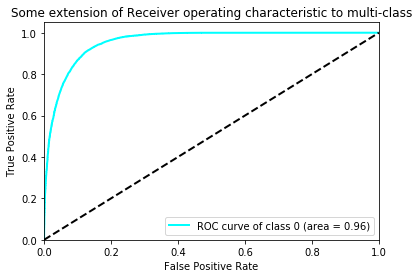

In [25]:
ROC_curve(np.expand_dims(np.array(y_true),1),np.expand_dims(np.array(y_score),2)[:,1])